In [ ]:
pip install pyproj

In [ ]:
# 모듈 모음
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import os

# 시각화 모듈
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
plt.rc("font", family="AppleGothic")
plt.rcParams['axes.unicode_minus'] = False
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# 히트맵 모듈
from folium.features import DivIcon
import folium

# 위도 경도 바꾸는 모듈
import pyproj # WGS84로
from pyproj import Proj, transform

# 경고 무시 모듈
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# 드라이브 가져오기
from google.colab import drive
drive.mount('/content/drive')

# **1. 데이터 불러오기 및 확인**

In [ ]:
import pandas as pd
raw_df = pd.read_csv("/content/drive/MyDrive/competition/소방안전 AI 예측/02.격자단위_구급출동_dataset.csv")
df = raw_df
df.head()

In [ ]:
# 데이터프레임 info 함수
df.info()


- **MONTH / DAY / WEEKDAY 컬럼 추가**

In [ ]:
import datetime

# 요일 0 ~ 6 정수값 return (월요일 ~ 일요일)
def get_weekday(ymd):
    yyyy = int(ymd/10000)
    mm = int(ymd%10000/100)    
    dd = int(ymd%10000%100)  
    return datetime.date(yyyy,mm,dd).weekday()

## apply 함수
df["MONTH"] = df["YMD"].apply(lambda x : int(x%10000/100) )
df["DAY"] = df["YMD"].apply(lambda x : int(x%10000%100) )
df["WEEKDAY"] = df["YMD"].apply(get_weekday)

df

# **2. 출동 빈도 지수 EDA** 

In [ ]:
df["DSP_CNT_IDEX"].describe()

## **1). 격자별 출동 빈도 지수 비교**

**- pivot_table() : 컬럼 기준으로 데이터 변환**

In [ ]:
import numpy as np
# 격자 ID 기준으로 DSP_CNT_IDEX 값을 SUM 기준으로 피벗 테이블 생성
rect_table = pd.pivot_table(df, values= "DSP_CNT_IDEX" , index=['GRID_ID'], aggfunc=np.sum)
rect_table["GRID_ID"] = rect_table.index.values
rect_table

In [ ]:
## 격자별 출동빈도 지수 피벗 테이블
rect_table["DSP_CNT_IDEX"]

In [ ]:
## 격자별 출동빈도 지수 피벗 테이블
rect_table["DSP_CNT_IDEX"].describe()

In [ ]:
# 1년간 500번 이상 출동된 격자 ID
rect_table["DSP_CNT_IDEX"][rect_table["DSP_CNT_IDEX"] > 500]

In [ ]:
# 1년간 출동횟수가 0 인 격자 ID
rect_table["DSP_CNT_IDEX"][rect_table["DSP_CNT_IDEX"] == 0]

## 2). 시간대별 출동 빈도 지수 비교

In [ ]:
import numpy as np
# pivot_table 함수
time_idex = pd.pivot_table(df, values= ["DSP_CNT_IDEX"] , index=['TIME'], aggfunc=np.mean)
time_idex["HOUR"] = time_idex.index.values
time_idex

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# seaborn barplot
plt.figure(figsize = (16,9))
sns.barplot(x="HOUR", y="DSP_CNT_IDEX", data=time_idex)

## **3). 요일별 출동 빈도 시각화**

In [ ]:
weekday_idx = pd.pivot_table(df, values= "DSP_CNT_IDEX" , index=['WEEKDAY'], aggfunc=np.mean)
weekday_idx["WEEKDAY"] = weekday_idx.index.values
weekday_idx

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x="WEEKDAY", y="DSP_CNT_IDEX", data=weekday_idx)

## **4). 월별 출동 빈도 지수 시각화**

In [ ]:
month_idx = pd.pivot_table(df, values= ["DSP_CNT_IDEX"] , index=['MONTH'], aggfunc=np.mean)
month_idx["MONTH"] = month_idx.index.values
month_idx

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x="MONTH", y="DSP_CNT_IDEX", data=month_idx)

## **5). 출동 장소 시각화**

In [ ]:
raw_df.columns

In [ ]:
sum_raw = pd.DataFrame(raw_df.sum()).T
place = sum_raw[['RELIFPLC_DWL_IDEX', 'RELIFPLC_ROAD_IDEX',
       'RELIFPLC_INDUST_IDEX', 'RELIFPLC_NTR_IDEX', 'RELIFPLC_ETC_IDEX']].T
place = place.rename(columns={0:'cnt'})
relifplc_tot = place['cnt'].sum()
place['prop'] = (place['cnt']/relifplc_tot)*100
place

In [ ]:
plt.figure(figsize = (16,9))
sns.barplot(x=place.index, y='prop', data=place)
# 차례대로 구급처가 주거, 교통, 산업, 자연, 기타순이다.
# 주거가 압도적으로 많은 것을 확인할 수 있다.
# 각 퍼센트 - 주거: 60.2%, 교통: 22.2%, 산업: 6.6%, 자연: 2.4%, 기타: 8.6

## **6). 질병 출동건수**

In [ ]:
sum_dis = pd.DataFrame(sum_raw[['DISEASE_DSP_IDEX', 'DISEASE_EXCL_DSP_IDEX']].T).rename(columns={0:'cnt'})
print(sum_dis)
sns.barplot(x=sum_dis.index,y='cnt',data=sum_dis)
# 질병 외 출동이 질병 출동보다 더 많이 출동한걸 확인할 수 있다.

# **3. 전처리 및 학습데이터셋 생성**

## **1). 출동 빈도가 높은 데이터 추출**

In [ ]:
rect_table['DSP_CNT_IDEX'].sort_values()

In [ ]:
## 격자 중에 출동이 52 번이 넘게 COUNT 되는 격자 추출 = 46개 격자
# => 52번의 기준: 평균적으로 1주일에 한번은 출동이 있었다. (1년 대략 52주)
many_dsp = np.where(rect_table["DSP_CNT_IDEX"] > 52)[0]
many_dsp , len(rect_table.values[many_dsp])

In [ ]:
# 격자 중에 출동이 50 번이 넘게 COUNT 되는 격자 GRID_ID 값들
many_dsp_GRID_ID = rect_table.index.values[many_dsp]
many_dsp_GRID_ID

In [ ]:
many_dsp_df = df[df["GRID_ID"].apply(lambda x :  x in many_dsp_GRID_ID)]
# 38만 ROW 데이터
many_dsp_df

In [ ]:
# 전체 데이터 대신 추출데이터 사용
df = many_dsp_df.reset_index(drop=True)
df.head()

*  변수가 부족하여 변수 추가를 위한 검색을 해본 결과, 2021년 119 구급서비스 통계연보에서 연령별 현황을 보았을 때(아래 그림 참조) 40대 이상의 이송인원이 전체의 80%에 가까웠다. 따라서 (1) 40대 이상과 미만의 인구수와 총 구급출동 횟수와 관련이 있는지 확인해보았다. 또한 위에서 보았듯이 월에 따른 추이가 있는걸로 보아 (2) 온도와 연관이 있어보여 각 읍/면/동의 온도를 추가했다. 별개로 교통사고와 강수는 관련이 있어서 강수형태의 데이터를 추가를 생각했지만, 총 응급출동 횟수 중 교통에서 일어난 횟수가 많지 않아 제외했다.


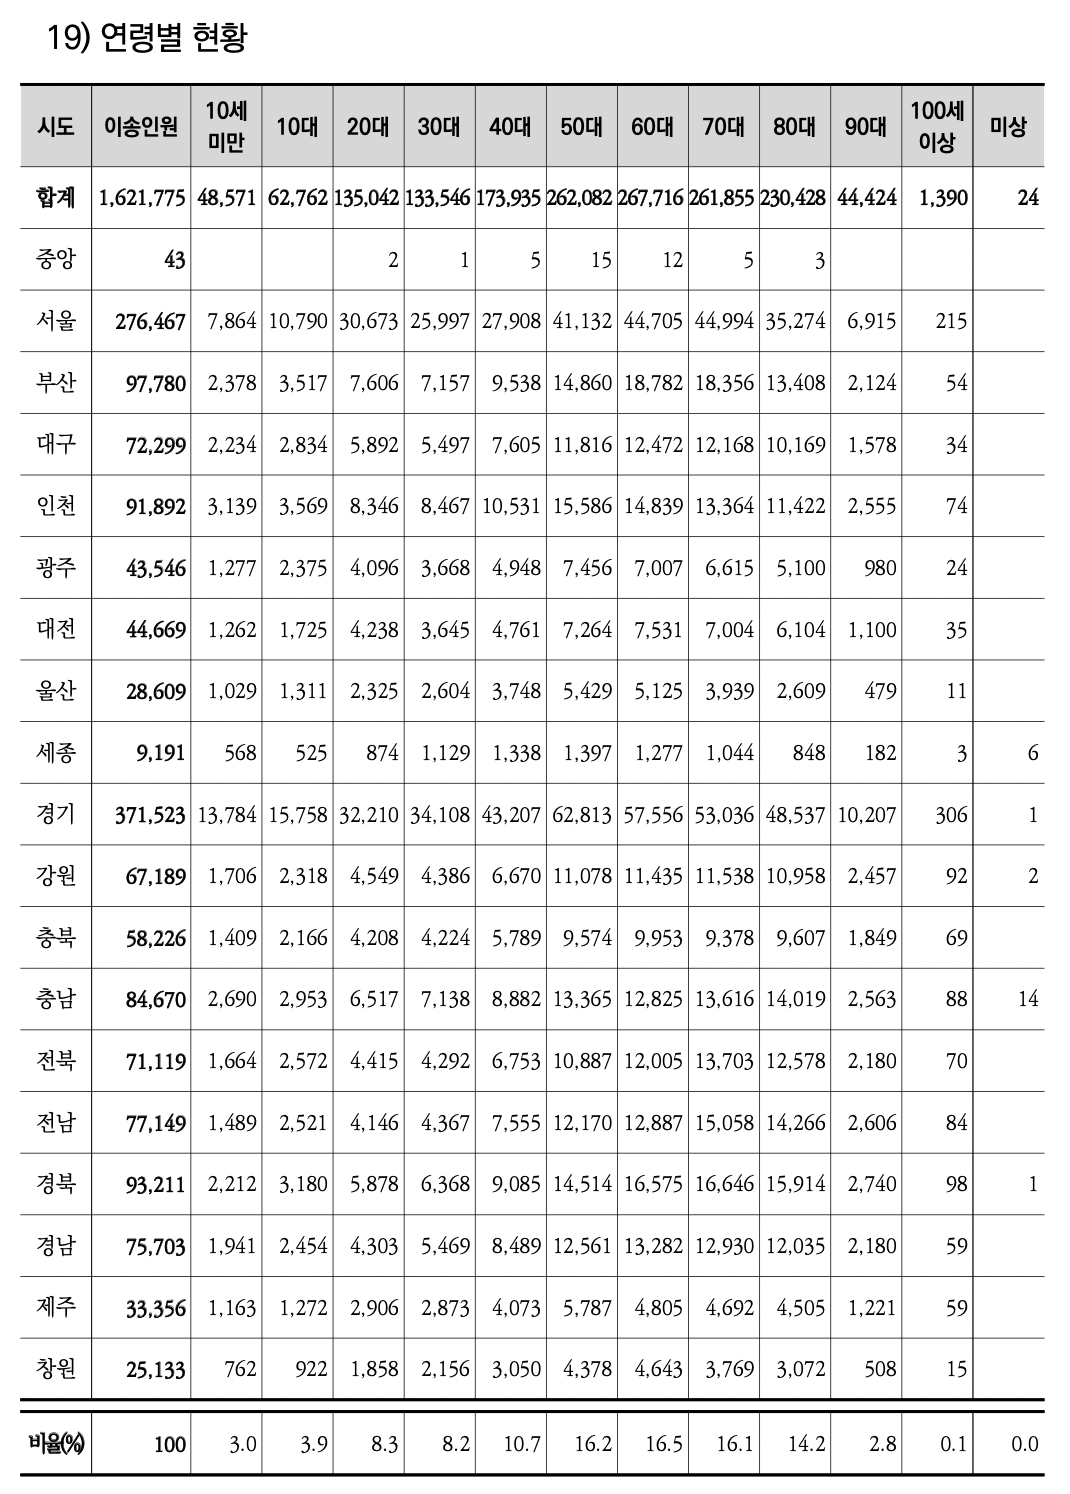

## **2). 연령별 인구 데이터 추가 전 확인**

In [ ]:
# katec을 위도, 경도로 바꾸는 함수
def katec_to_wgs84(x, y):
    inProj  = Proj('+proj=tmerc +lat_0=38 +lon_0=128 +k=0.9999 +x_0=400000 +y_0=600000 +ellps=bessel +units=m +no_defs +towgs84=-115.80,474.99,674.11,1.16,-2.31,-1.63,6.43')
    outProj = Proj({ 'proj':'latlong', 'datum':'WGS84', 'ellps':'WGS84' })
    return transform( inProj, outProj, x, y )

In [ ]:
# daydf: id를 기준으로 총 몇번의 출동이 있었는지 볼 수 있는 피벗테이블
daydf = df[['GRID_ID', 'GRID_X_AXIS', 'GRID_Y_AXIS','DSP_CNT_IDEX']].groupby(['GRID_ID', 'GRID_X_AXIS', 'GRID_Y_AXIS']).sum().reset_index()
# geodf: daydf의 컬럼 네임을 변경해서 볼 수 있는 데이터 프레임
geodf = daydf.rename(columns = {'GRID_ID' : 'id','GRID_X_AXIS':'x', 'GRID_Y_AXIS':'y', 'DSP_CNT_IDEX':'total'})
# id, x, y, total 값만 확인
geodf = geodf[['id','x','y','total']]
# katec 값인 x,y를 wsg84로 변환
geodf['lng'], geodf['lat'] = katec_to_wgs84(geodf.x.to_list(), geodf.y.to_list())

In [ ]:
# 위도와 경도가 추가된 geodf 확인
geodf.head()

In [ ]:
# 위도, 경도를 도로명주소로 변환해주는 API 사용하여 geodf에 도,시,읍/면/동 변수를 생성
# geodf['address_do'] : 도
# geodf['address_si'] : 시
# geodf['address_emd'] : 읍/면/동

for i in range(len(geodf)):
  x_lng = geodf.iloc[i].lng
  y_lat = geodf.iloc[i].lat
  url = f"http://apis.vworld.kr/coord2jibun.do?x={x_lng}&y={y_lat}&output=json&epsg=epsg:4326&apiKey=5783B04C-6D2F-333B-823A-489D1E5FDB3B"
  resp = requests.get(url)
  data=resp.json()
  add = data['ADDR'].split(' ')
  geodf.loc[i,'address_do']=add[0]
  geodf.loc[i,'address_si']=add[1]
  geodf.loc[i,'address_emd']=add[2]



In [ ]:
# 생성된 도,시,읍/면/동 변수 확인
print(geodf)

In [ ]:
# geodf csv로 저장(코랩 런타임 지나 다시 사용할 목적)
# geodf.to_csv('geodf.csv',encoding='utf-8-sig')

In [ ]:
# 52번 이상 있었던 격자, 모두 강원도 원주시 나오는 것 확인 가능
onlywj = geodf[geodf["id"].apply(lambda x :  x in many_dsp_GRID_ID)]
onlywj

In [ ]:
# 각 동의 총 합 확인
count_dong = pd.pivot_table(onlywj,index=['address_emd'], values='total',aggfunc=sum)
count_dong = count_dong.reset_index()
count_dong

In [ ]:
# 각 동의 총인구수의 평균데이터 가져오기
average_pop = pd.read_csv('/content/drive/MyDrive/competition/소방안전 AI 예측/average_population.csv',encoding='euc-kr')
average_pop = average_pop[['행정구역(동읍면)별','average']]
average_pop = average_pop.rename(columns={'행정구역(동읍면)별':'address_emd'})
average_pop

In [ ]:
# geodf에서 가현동은 우산동으로, 반곡동과 관설동은 반곡관설동으로 바꾸어준다.
# 국가통계포털에 있는 데이터의 경우 가현동을 우산동과 동일시 하는 것 같다.
for i in range(len(geodf)):
  if geodf.iloc[i,8]=='가현동':
    geodf.iloc[i,8]='우산동'
  elif geodf.iloc[i,8]=='반곡동':
    geodf.iloc[i,8]='반곡관설동'
  elif geodf.iloc[i,8]=='관설동':
    geodf.iloc[i,8]='반곡관설동'
  else:
    pass

In [ ]:
geodf.head()

In [ ]:
# 가현동과 반곡관설동을 바꿔준 동의 총합데이터 다시구하기
onlywj = geodf[geodf["id"].apply(lambda x :  x in many_dsp_GRID_ID)]
count_dong = pd.pivot_table(onlywj,index=['address_emd'], values='total',aggfunc=sum)
count_dong = count_dong.reset_index()
count_dong

In [ ]:
# 각 읍/면/동 평균인구수와 총 출동횟수의 관계보기
popandcnt = pd.merge(count_dong,average_pop,on='address_emd',how='inner')
popandcnt['average'] = popandcnt['average']/100
popandcnt = popandcnt.sort_values(by='average',ascending=False)
popandcnt

In [ ]:
len(popandcnt['address_emd'].unique())

In [ ]:
# 평균인구수를 내림차순으로 정렬했음에도 불구하고 인구수와 총출동횟수의 비례성을 찾기 힘들어보인다.
popandcnt.plot(x="address_emd", y=['total','average'], kind="bar",figsize=(9,8))
plt.show()

In [ ]:
# 인구수와 총 출동횟수의 관계성이 명확치않아 이번엔 40세를 기준으로 관계성을 확인해보았다.
# data(월별 원주시 읍면동인구수.csv): 2020년 1월부터 12월까지 40세 미만과 이상의 인구수를 구한 데이터이다.
# 2020.1.1은 1월달의 40세 미만 데이터, 2020.1.1.1d은 1월달의 40세 이상 데이터이다.
age_emd = pd.read_csv('/content/drive/MyDrive/competition/소방안전 AI 예측/월별 원주시 읍면동인구수.csv',encoding='euc-kr').iloc[:-2]
age_emd = age_emd.iloc[1:].rename(columns={'행정구역(동읍면)별':'address_emd'})
age_emd.set_index('address_emd',inplace=True)
age_emd.head()

In [ ]:
# 데이터 타입 변경
age_emd = age_emd.astype('int')
age_emd.dtypes

In [ ]:
# 일단 12월을 기준으로 관계성을 확인 해보았다.
age_twelve = age_emd[['2020.12.1','2020.12.1.1']].rename(columns={'2020.12.1':'40세미만','2020.12.1.1':'40세이상'}).reset_index()
age_twelve.head()

In [ ]:
# 총 출동횟수와와 나이인구수를 넣어 데이터를 합쳐주었다.
popageandcnt = pd.merge(count_dong,age_twelve,on='address_emd',how='inner')
# 10으로 나눠준 이유는 총 출동횟수와 그래프를 보는데 있어 편하게 보기 위함이다.
popageandcnt['40세미만'] = popageandcnt['40세미만']/10
popageandcnt['40세이상'] = popageandcnt['40세이상']/10
popageandcnt = popageandcnt.sort_values(by='total')
popageandcnt.head()

In [ ]:
# 각 읍면동별 40세미만과 총 출동횟수의 그래프
# 총 출동횟수를 오름차순으로 본 결과 40세미만의 인구수와 총 출동횟수의 관계의 비례가 없어보인다.
# 특히 총출동횟수가 가장 적은데 인구수가 많은 그래프 때문에 이 변수를 넣는덴 무리가 있어보인다.
popageandcnt.plot(x="address_emd", y=['total','40세미만'], kind="bar",figsize=(16,8))
plt.show()

In [ ]:
# 각 읍면동별 40세이상과 총 출동횟수의 그래프
# 총 출동횟수를 오름차순으로 본 결과 40세이상의 인구수와 총 출동횟수의 관계의 비례가 없어보인다.
# 관계의 무작위성 때문에 이 변수를 넣는덴 무리가 있어보인다.
popageandcnt.plot(x="address_emd", y=['total','40세이상'], kind="bar",figsize=(16,8))
plt.show()

## **3). 온도데이터 추가**

In [ ]:
# 온도데이터의 형태를 변환해주는 함수
# 컬럼명 변경, 월추가
def make_temp_data(temp_df):
  null_index = temp_df[temp_df['hour'].isnull()==True].index
  temp_df['MONTH'] = 0
  ttemp_df = temp_df[temp_df['hour'].isnull()==False].reset_index(drop=True).rename(columns={' format: day':'DAY', 'hour':'TIME', temp_df.columns[2]:'temp'})
  ttemp_df['TIME']=(ttemp_df['TIME']/100).astype(int)
  ttemp_df['DAY']=ttemp_df['DAY'].astype(int)
  for i in range(len(null_index)+1): 
    n = i
    if i==0:
      for j in range(null_index[i]):
        ttemp_df.iloc[j,3] = n+1
    elif i == 10:
      for j in range(null_index[i-1],null_index[i]):
        ttemp_df.iloc[j,3] = n+1
    else:
      for j in range(null_index[i-1],len(ttemp_df)):
        ttemp_df.iloc[j,3] = n+1
  return ttemp_df

In [ ]:
emd_name = geodf.address_emd.unique()


In [ ]:
len(emd_name)

In [ ]:
# 각 읍동의 온도데이터를 불러온다.
name_emd = emd_name[0]
temp_df_0 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_0 = make_temp_data(temp_df_0)

name_emd = emd_name[1]
temp_df_1 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_1 = make_temp_data(temp_df_1)

name_emd = emd_name[2]
temp_df_2 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_2 = make_temp_data(temp_df_2)

name_emd = emd_name[3]
temp_df_3 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_3 = make_temp_data(temp_df_3)

name_emd = emd_name[4]
temp_df_4 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_4 = make_temp_data(temp_df_4)

name_emd = emd_name[5]
temp_df_5 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_5 = make_temp_data(temp_df_5)

name_emd = emd_name[6]
temp_df_6 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_6 = make_temp_data(temp_df_6)

name_emd = emd_name[7]
temp_df_7 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_7 = make_temp_data(temp_df_7)

name_emd = emd_name[8]
temp_df_8 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_8 = make_temp_data(temp_df_8)

name_emd = emd_name[9]
temp_df_9 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_9 = make_temp_data(temp_df_9)

name_emd = emd_name[10]
temp_df_10 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_10 = make_temp_data(temp_df_10)



In [ ]:
name_emd = emd_name[11]
temp_df_11 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_11 = make_temp_data(temp_df_11)

name_emd = emd_name[12]
temp_df_12 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_12 = make_temp_data(temp_df_12)

name_emd = emd_name[13]
temp_df_13 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_13 = make_temp_data(temp_df_13)

name_emd = emd_name[14]
temp_df_14 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_14 = make_temp_data(temp_df_14)

name_emd = emd_name[15]
temp_df_15 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_15 = make_temp_data(temp_df_15)

name_emd = emd_name[16]
temp_df_16 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_16 = make_temp_data(temp_df_16)

name_emd = emd_name[17]
temp_df_17 = pd.read_csv(f'/content/drive/MyDrive/competition/소방안전 AI 예측/{name_emd}_기온_202001_202012.csv')
temp_df_17 = make_temp_data(temp_df_17)

In [ ]:
# 학습에 쓸 데이터 정의
use_df = df[['GRID_ID',"GRID_X_AXIS" , "GRID_Y_AXIS" , "MONTH" , "DAY" , "WEEKDAY" , "TIME" ]]
use_df['TEMP']=0
use_df

In [ ]:
# 각 동의 월/일/시별 온도데이터를 추가한다.
# count_dong['address_emd']에 모든 동의 이름이 있다.

In [ ]:
emd_set = count_dong['address_emd'][0]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_0)):
  month = temp_df_0.iloc[i,3]
  day = temp_df_0.iloc[i,0]
  time = temp_df_0.iloc[i,1]
  temp = temp_df_0.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][1]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_1)):
  month = temp_df_1.iloc[i,3]
  day = temp_df_1.iloc[i,0]
  time = temp_df_1.iloc[i,1]
  temp = temp_df_1.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][2]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_2)):
  month = temp_df_2.iloc[i,3]
  day = temp_df_2.iloc[i,0]
  time = temp_df_2.iloc[i,1]
  temp = temp_df_2.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][3]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_3)):
  month = temp_df_3.iloc[i,3]
  day = temp_df_3.iloc[i,0]
  time = temp_df_3.iloc[i,1]
  temp = temp_df_3.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][4]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_4)):
  month = temp_df_4.iloc[i,3]
  day = temp_df_4.iloc[i,0]
  time = temp_df_4.iloc[i,1]
  temp = temp_df_4.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][5]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_5)):
  month = temp_df_5.iloc[i,3]
  day = temp_df_5.iloc[i,0]
  time = temp_df_5.iloc[i,1]
  temp = temp_df_5.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][6]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_6)):
  month = temp_df_6.iloc[i,3]
  day = temp_df_6.iloc[i,0]
  time = temp_df_6.iloc[i,1]
  temp = temp_df_6.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][7]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_7)):
  month = temp_df_7.iloc[i,3]
  day = temp_df_7.iloc[i,0]
  time = temp_df_7.iloc[i,1]
  temp = temp_df_7.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][8]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_8)):
  month = temp_df_8.iloc[i,3]
  day = temp_df_8.iloc[i,0]
  time = temp_df_8.iloc[i,1]
  temp = temp_df_8.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][9]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_9)):
  month = temp_df_9.iloc[i,3]
  day = temp_df_9.iloc[i,0]
  time = temp_df_9.iloc[i,1]
  temp = temp_df_9.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][10]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_10)):
  month = temp_df_10.iloc[i,3]
  day = temp_df_10.iloc[i,0]
  time = temp_df_10.iloc[i,1]
  temp = temp_df_10.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][11]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_11)):
  month = temp_df_11.iloc[i,3]
  day = temp_df_11.iloc[i,0]
  time = temp_df_11.iloc[i,1]
  temp = temp_df_11.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][12]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_12)):
  month = temp_df_12.iloc[i,3]
  day = temp_df_12.iloc[i,0]
  time = temp_df_12.iloc[i,1]
  temp = temp_df_12.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][13]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_13)):
  month = temp_df_13.iloc[i,3]
  day = temp_df_13.iloc[i,0]
  time = temp_df_13.iloc[i,1]
  temp = temp_df_13.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][14]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_14)):
  month = temp_df_14.iloc[i,3]
  day = temp_df_14.iloc[i,0]
  time = temp_df_14.iloc[i,1]
  temp = temp_df_14.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][15]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_15)):
  month = temp_df_15.iloc[i,3]
  day = temp_df_15.iloc[i,0]
  time = temp_df_15.iloc[i,1]
  temp = temp_df_15.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][16]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_16)):
  month = temp_df_16.iloc[i,3]
  day = temp_df_16.iloc[i,0]
  time = temp_df_16.iloc[i,1]
  temp = temp_df_16.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][17]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = use_df[use_df["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_17)):
  month = temp_df_17.iloc[i,3]
  day = temp_df_17.iloc[i,0]
  time = temp_df_17.iloc[i,1]
  temp = temp_df_17.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  use_df.iloc[aboutindex,7] = temp

In [ ]:
# 최종적으로 사용할 데이터
use_df.head()

## **4). One-Hot-Encoding**

In [ ]:
# 원핫인코딩으로로 아이디값을을 처리해준다.
ENC_GRID_ID_df = pd.get_dummies(use_df["GRID_ID"])
ENC_GRID_ID_df

## **3). 학습/테스트 데이터셋 구축**

- **pd.concat() : 데이터프레임 합치기**

In [ ]:

## 입력 데이터셋 = [OneHotEncoding 된 격자 id 데이터 / 격자 X 좌표 / 격자 Y 좌표 / 월 / 날짜 / 요일 / 시간대 / 온도]

X_df = use_df[["GRID_X_AXIS" , "GRID_Y_AXIS" , "MONTH" , "DAY" , "WEEKDAY" , "TIME", "TEMP" ]]
X_df = pd.concat( [ENC_GRID_ID_df , X_df ] , axis = 1)

Y_df = df[["DSP_CNT_IDEX"]]

X_df.shape , Y_df.shape


- **train_test_split()  :  학습데이터 / 테스트 데이터 분할**

In [ ]:
from sklearn.model_selection import train_test_split

X_train , X_test , Y_train , Y_test = train_test_split(X_df , Y_df , test_size = 0.3  , random_state=2)

In [ ]:
X_train.shape , X_test.shape , Y_train.shape , Y_test.shape

In [ ]:
len(use_df.GRID_ID.unique())

# **4. 출동 빈도 지수 예측 모델**

## **1). RandomForest Model**

In [ ]:
%%time

from sklearn.ensemble import RandomForestRegressor

# RandomForest 모델 생성
rf_model = RandomForestRegressor(n_estimators = 100, random_state = 15)

# 학습데이터셋으로 학습
rf_model.fit(X_train, Y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

preds = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, preds))

print("RF - RMSE: %f" % (rmse))

In [ ]:
use_df

In [ ]:
raw_df[raw_df['GRID_ID']==39545274].sum()['DSP_CNT_IDEX']

In [ ]:
use_df[use_df['GRID_ID']==39545274]

In [ ]:
Y_test.sort_values(by='DSP_CNT_IDEX')

In [ ]:
X_train

In [ ]:
use_df

In [ ]:
use_df.iloc[:1104]

In [ ]:
# 제출할 데이터셋 만들
x_real_test_jan = use_df.iloc[:1087].copy()
x_real_test_jan['DAY']=31


In [ ]:

x_real_test_feb = use_df.iloc[:1087].copy()
x_real_test_feb['MONTH']=2
x_real_test_feb['DAY']=28


In [ ]:

x_real_test_mar = use_df.iloc[:1087].copy()
x_real_test_mar['MONTH']=3
x_real_test_mar['DAY']=31


In [ ]:

x_real_test_apr = use_df.iloc[:1087].copy()
x_real_test_apr['MONTH']=4
x_real_test_apr['DAY']=30


In [ ]:

x_real_test_may = use_df.iloc[:1087].copy()
x_real_test_may['MONTH']=5
x_real_test_may['DAY']=31


In [ ]:

x_real_test_jun = use_df.iloc[:1087].copy()
x_real_test_jun['MONTH']=6
x_real_test_jun['DAY']=30


In [ ]:

x_real_test_jul = use_df.iloc[:1087].copy()
x_real_test_jul['MONTH']=7
x_real_test_jul['DAY']=31


In [ ]:

x_real_test_aug = use_df.iloc[:1087].copy()
x_real_test_aug['MONTH']=8
x_real_test_aug['DAY']=31


In [ ]:

x_real_test_sep = use_df.iloc[:1087].copy()
x_real_test_sep['MONTH']=9
x_real_test_sep['DAY']=30


In [ ]:

x_real_test_oct = use_df.iloc[:1087].copy()
x_real_test_oct['MONTH']=10
x_real_test_oct['DAY']=31


In [ ]:

x_real_test_nov = use_df.iloc[:1087].copy()
x_real_test_nov['MONTH']=11
x_real_test_nov['DAY']=30


In [ ]:

x_real_test_dec = use_df.iloc[:1087].copy()
x_real_test_dec['MONTH']=12
x_real_test_dec['DAY']=31

In [ ]:
x_real_test_jan.shape

In [ ]:
x_real_test = pd.concat([x_real_test_jan,x_real_test_feb,x_real_test_mar,x_real_test_apr,x_real_test_may,x_real_test_jun,x_real_test_jul,x_real_test_aug,x_real_test_sep,x_real_test_oct,x_real_test_nov,x_real_test_dec])
x_real_test

In [ ]:
# use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
# use_df0[(use_df0['MONTH']==1)&(use_df0['DAY']==31)&(use_df0['TIME']==0)].index
# x_real_test.iloc[30]

In [ ]:
# use_df0.iloc[30]

In [ ]:
# x_real_test.iloc[30]

In [ ]:
# 해당날짜의온도채워주기
emd_set = count_dong['address_emd'][0]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_0)):
  month = temp_df_0.iloc[i,3]
  day = temp_df_0.iloc[i,0]
  time = temp_df_0.iloc[i,1]
  temp = temp_df_0.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][1]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_1)):
  month = temp_df_1.iloc[i,3]
  day = temp_df_1.iloc[i,0]
  time = temp_df_1.iloc[i,1]
  temp = temp_df_1.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][2]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_2)):
  month = temp_df_2.iloc[i,3]
  day = temp_df_2.iloc[i,0]
  time = temp_df_2.iloc[i,1]
  temp = temp_df_2.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][3]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values

use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_3)):
  month = temp_df_3.iloc[i,3]
  day = temp_df_3.iloc[i,0]
  time = temp_df_3.iloc[i,1]
  temp = temp_df_3.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][4]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_4)):
  month = temp_df_4.iloc[i,3]
  day = temp_df_4.iloc[i,0]
  time = temp_df_4.iloc[i,1]
  temp = temp_df_4.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][5]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_5)):
  month = temp_df_5.iloc[i,3]
  day = temp_df_5.iloc[i,0]
  time = temp_df_5.iloc[i,1]
  temp = temp_df_5.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][6]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_6)):
  month = temp_df_6.iloc[i,3]
  day = temp_df_6.iloc[i,0]
  time = temp_df_6.iloc[i,1]
  temp = temp_df_6.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][7]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_7)):
  month = temp_df_7.iloc[i,3]
  day = temp_df_7.iloc[i,0]
  time = temp_df_7.iloc[i,1]
  temp = temp_df_7.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][8]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_8)):
  month = temp_df_8.iloc[i,3]
  day = temp_df_8.iloc[i,0]
  time = temp_df_8.iloc[i,1]
  temp = temp_df_8.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][9]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_9)):
  month = temp_df_9.iloc[i,3]
  day = temp_df_9.iloc[i,0]
  time = temp_df_9.iloc[i,1]
  temp = temp_df_9.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][10]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_10)):
  month = temp_df_10.iloc[i,3]
  day = temp_df_10.iloc[i,0]
  time = temp_df_10.iloc[i,1]
  temp = temp_df_10.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][11]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_11)):
  month = temp_df_11.iloc[i,3]
  day = temp_df_11.iloc[i,0]
  time = temp_df_11.iloc[i,1]
  temp = temp_df_11.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][12]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_12)):
  month = temp_df_12.iloc[i,3]
  day = temp_df_12.iloc[i,0]
  time = temp_df_12.iloc[i,1]
  temp = temp_df_12.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][13]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_13)):
  month = temp_df_13.iloc[i,3]
  day = temp_df_13.iloc[i,0]
  time = temp_df_13.iloc[i,1]
  temp = temp_df_13.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][14]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_14)):
  month = temp_df_14.iloc[i,3]
  day = temp_df_14.iloc[i,0]
  time = temp_df_14.iloc[i,1]
  temp = temp_df_14.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][15]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_15)):
  month = temp_df_15.iloc[i,3]
  day = temp_df_15.iloc[i,0]
  time = temp_df_15.iloc[i,1]
  temp = temp_df_15.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][16]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_16)):
  month = temp_df_16.iloc[i,3]
  day = temp_df_16.iloc[i,0]
  time = temp_df_16.iloc[i,1]
  temp = temp_df_16.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
emd_set = count_dong['address_emd'][17]
grid_ids = geodf[geodf['address_emd']== emd_set]['id'].values
use_df0 = x_real_test[x_real_test["GRID_ID"].apply(lambda x :  x in grid_ids)]
for i in range(len(temp_df_17)):
  month = temp_df_17.iloc[i,3]
  day = temp_df_17.iloc[i,0]
  time = temp_df_17.iloc[i,1]
  temp = temp_df_17.iloc[i,2]
  aboutindex = use_df0[(use_df0['MONTH']==month)&(use_df0['DAY']==day)&(use_df0['TIME']==time)].index
  x_real_test.iloc[aboutindex,7] = temp

In [ ]:
# 원핫인코딩으로로 아이디값을을 처리해준다.
ENC_GRID_ID_df_test = pd.get_dummies(x_real_test["GRID_ID"])
ENC_GRID_ID_df_test

In [ ]:

## 입력 데이터셋 = [OneHotEncoding 된 격자 id 데이터 / 격자 X 좌표 / 격자 Y 좌표 / 월 / 날짜 / 요일 / 시간대 / 온도]

X_df_test1 = x_real_test[["GRID_X_AXIS" , "GRID_Y_AXIS" , "MONTH" , "DAY" , "WEEKDAY" , "TIME", "TEMP" ]]
X_df_test2 = pd.concat( [ENC_GRID_ID_df_test , X_df_test1 ] , axis = 1)

In [ ]:
preds = rf_model.predict(X_df_test2)

In [ ]:
pred_df = pd.DataFrame(preds).rename(columns={0:'pred'})
pred_df
x_test_id = x_real_test[['GRID_ID', "MONTH" , "DAY" ,  "TIME"]].reset_index(drop=True)
x_test_id

In [ ]:
pred_final_df = pd.concat([x_test_id,pred_df],axis=1)
pred_final_df

In [ ]:
new_df = pd.DataFrame(columns=['GRID_ID','MONTH','DAY','TIME','pred'])
for i in range(1,13):
  for j in range(0,24):
    jan_zero = pred_final_df[(pred_final_df['MONTH']==i)&(pred_final_df['TIME']==j)]
    jan_zero = pd.DataFrame(jan_zero.loc[jan_zero['pred'].idxmax()]).T
    new_df = pd.concat([new_df, jan_zero])

In [ ]:
new_df=new_df.reset_index(drop=True)
new_df

In [ ]:
new_df.columns

In [ ]:
new_df = new_df.astype({'GRID_ID':'int', 'MONTH':'int', 'DAY':'int', 'TIME':'int'})

In [ ]:
new_df

In [ ]:
rf_model.get_params().keys()

In [ ]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
dists = {
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1) # max_features
}

clf_rf = RandomizedSearchCV(
    rf_model, 
    param_distributions=dists, 
    n_iter=10, 
    cv=5, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)
clf_rf.fit(X_train, Y_train)
print('최적 하이퍼파라미터: ', clf_rf.best_params_)
print('r2: ', clf_rf.best_score_)

In [ ]:
preds1_1 = clf_rf.predict(X_test)
rmse1_1 = np.sqrt(mean_squared_error(Y_test, preds1_1))
print("RF_hyper - RMSE: %f" % (rmse1_1))

## **2). XGBoost Model**

In [ ]:
%%time

import xgboost

xgb_model = xgboost.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xgb_model.fit(X_train,Y_train)


In [ ]:
from sklearn.metrics import mean_squared_error

preds = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, preds))
print("XGB - RMSE: %f" % (rmse))
print("XGB - RMSE: %f" % r2_score(Y_test,preds))


In [ ]:
preds2 = xgb_model.predict(X_df_test2)

In [ ]:
pred_df2= pd.DataFrame(preds2).rename(columns={0:'pred'})
pred_df2
x_test_id2 = x_real_test[['GRID_ID', "MONTH" , "DAY" ,  "TIME"]].reset_index(drop=True)
x_test_id2

In [ ]:
pred_final_df2 = pd.concat([x_test_id,pred_df2],axis=1)
pred_final_df2

In [ ]:
new_df2 = pd.DataFrame(columns=['GRID_ID','MONTH','DAY','TIME','pred'])
for i in range(1,13):
  for j in range(0,24):
    jan_zero2 = pred_final_df2[(pred_final_df2['MONTH']==i)&(pred_final_df2['TIME']==j)]
    jan_zero2 = pd.DataFrame(jan_zero2.loc[jan_zero2['pred'].idxmax()]).T
    new_df2 = pd.concat([new_df2, jan_zero2])

In [ ]:
new_df2=new_df2.reset_index(drop=True)
new_df2

In [ ]:
new_df.columns

In [ ]:
new_df2 = new_df2.astype({'GRID_ID':'int', 'MONTH':'int', 'DAY':'int', 'TIME':'int'})

In [ ]:
new_df2

In [ ]:
X_train

## **3).DNN Model**

In [ ]:
%%time

import tensorflow as tf
from keras.layers import BatchNormalization, Dropout
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import models
from keras import layers
from keras import optimizers


## 모델 생성 
model = Sequential()
model.add(Dense(64 , input_dim = 53 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dropout(0.3))
model.add(layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae' , 'mse'])


# 모델 학습
hist = model.fit(X_train , Y_train , epochs = 10 , batch_size = 16)



In [ ]:
# 모델 summary()
model.summary()

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score

# 테스트데이터 예측 및 RMSE 계산
preds3 = model.predict(X_test)
rmse3 = np.sqrt(mean_squared_error(Y_test, preds3))
print("DNN Model - RMSE: %f" % (rmse3))
print("DNN Model - R2: %f" % r2_score(Y_test,preds3))


# **5. 결론 및 보완점**